# Best Model Test

This notebook tests the best trained RL model performance with the current network configuration:
- **Model**: Best trained DuelingDQN model from `models/best_models/best_model.pt`
- **Network Size**: Tests with current number of operational nodes
- **Terminal Pairs**: Multiple source-destination pairs
- **Metrics**: Success rate, path length, latency, hops, efficiency
- **Comparison**: Can compare with Dijkstra baseline


## 1. Setup & Configuration


In [1]:
# Setup paths and imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import warnings
import time
import torch
warnings.filterwarnings('ignore')

# Add backend to path
backend_path = os.path.abspath('..')
if backend_path not in sys.path:
    sys.path.insert(0, backend_path)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✓ Setup complete")


✓ Setup complete


In [2]:
# Import project modules
from config import Config
from models.database import Database
from api.routing_bp import calculate_path_rl, calculate_path_dijkstra, calculate_distance
from services.rl_routing_service import get_rl_routing_service

# Initialize
config = Config.get_yaml_config()
db = Database()
db.connect()

print("✓ Modules loaded")
print(f"✓ Database connected: {db.db.name}")
print(f"✓ Config loaded")


✓ Modules loaded
✓ Database connected: aiprancs
✓ Config loaded


## 2. Load Network Data


In [3]:
# Load nodes and terminals from database
nodes_collection = db.get_collection('nodes')
terminals_collection = db.get_collection('terminals')

# Get operational nodes
nodes = list(nodes_collection.find({'isOperational': True}, {'_id': 0}))
terminals = list(terminals_collection.find({}, {'_id': 0}))

# Count total nodes
total_nodes = nodes_collection.count_documents({})
operational_nodes = len(nodes)

print(f"📊 Network Statistics:")
print(f"  Total nodes in database: {total_nodes}")
print(f"  Operational nodes: {operational_nodes}")
print(f"  Total terminals: {len(terminals)}")
print(f"\n📡 Node Types:")
node_types = {}
for node in nodes:
    node_type = node.get('nodeType', 'UNKNOWN')
    node_types[node_type] = node_types.get(node_type, 0) + 1
for node_type, count in node_types.items():
    print(f"  {node_type}: {count}")

print(f"\n✓ Network data loaded")


📊 Network Statistics:
  Total nodes in database: 83
  Operational nodes: 83
  Total terminals: 92

📡 Node Types:
  LEO_SATELLITE: 40
  MEO_SATELLITE: 12
  GEO_SATELLITE: 3
  GROUND_STATION: 28

✓ Network data loaded


## 3. Load Best Model


In [4]:
# Check if best model exists
MODEL_PATH = Path('../models/best_models/best_model.pt')

if MODEL_PATH.exists():
    print(f"📦 Best model found at: {MODEL_PATH}")
    print(f"   File size: {MODEL_PATH.stat().st_size / (1024*1024):.2f} MB")
    
    # Initialize RL service (will load model automatically)
    try:
        rl_service = get_rl_routing_service(config)
        print("✓ RL service initialized")
        print("✓ Best model will be loaded on first routing request")
    except Exception as e:
        logger.error(f"Failed to initialize RL service: {e}")
        rl_service = None
else:
    print(f"❌ Best model not found at: {MODEL_PATH}")
    print("   Run training first: python training/train.py")
    rl_service = None


📦 Best model found at: ../models/best_models/best_model.pt
   File size: 4.94 MB
✓ RL service initialized
✓ Best model will be loaded on first routing request


## 4. RL Routing Test Function


In [5]:
def test_rl_routing(
    nodes: List[Dict],
    terminals: List[Dict],
    num_tests: int = 50
) -> pd.DataFrame:
    """
    Test RL routing with multiple terminal pairs
    
    Args:
        nodes: List of operational nodes
        terminals: List of terminals
        num_tests: Number of test cases
    
    Returns:
        DataFrame with test results
    """
    logger.info("=" * 60)
    logger.info(f"Testing RL Routing with Best Model ({num_tests} test cases)")
    logger.info("=" * 60)
    
    if len(terminals) < 2:
        logger.error("Need at least 2 terminals for testing")
        return None
    
    if rl_service is None:
        logger.error("RL service not initialized")
        return None
    
    results = []
    successful = 0
    failed = 0
    
    for i in range(num_tests):
        # Randomly select source and destination terminals
        terminal_indices = np.random.choice(len(terminals), size=2, replace=False)
        source_terminal = terminals[terminal_indices[0]]
        dest_terminal = terminals[terminal_indices[1]]
        
        # Calculate distance between terminals
        source_pos = source_terminal.get('position', {})
        dest_pos = dest_terminal.get('position', {})
        terminal_distance = calculate_distance(source_pos, dest_pos) / 1000  # km
        
        start_time = time.time()
        
        try:
            # Calculate path using RL
            path_result = calculate_path_rl(
                source_terminal=source_terminal,
                dest_terminal=dest_terminal,
                nodes=nodes,
                service_qos=None
            )
            
            elapsed_time = time.time() - start_time
            
            if path_result and path_result.get('success', False):
                path = path_result.get('path', [])
                path_nodes = [p for p in path if p.get('type') == 'node']
                hops = len(path_nodes)
                total_distance = path_result.get('totalDistance', 0)  # km
                total_latency = path_result.get('estimatedLatency', 0)  # ms
                
                # Calculate path efficiency
                efficiency = terminal_distance / total_distance if total_distance > 0 else 0
                
                results.append({
                    'test_id': i + 1,
                    'source_terminal': source_terminal.get('terminalId'),
                    'dest_terminal': dest_terminal.get('terminalId'),
                    'success': True,
                    'hops': hops,
                    'total_distance_km': total_distance,
                    'terminal_distance_km': terminal_distance,
                    'total_latency_ms': total_latency,
                    'efficiency': efficiency,
                    'computation_time_ms': elapsed_time * 1000,
                    'path_length': len(path),
                    'error': None
                })
                successful += 1
            else:
                error_msg = path_result.get('error', 'Unknown error') if path_result else 'No path found'
                results.append({
                    'test_id': i + 1,
                    'source_terminal': source_terminal.get('terminalId'),
                    'dest_terminal': dest_terminal.get('terminalId'),
                    'success': False,
                    'hops': 0,
                    'total_distance_km': 0,
                    'terminal_distance_km': terminal_distance,
                    'total_latency_ms': 0,
                    'efficiency': 0,
                    'computation_time_ms': elapsed_time * 1000,
                    'path_length': 0,
                    'error': error_msg
                })
                failed += 1
                
        except Exception as e:
            elapsed_time = time.time() - start_time
            logger.warning(f"Test {i+1} failed with exception: {e}")
            results.append({
                'test_id': i + 1,
                'source_terminal': source_terminal.get('terminalId'),
                'dest_terminal': dest_terminal.get('terminalId'),
                'success': False,
                'hops': 0,
                'total_distance_km': 0,
                'terminal_distance_km': terminal_distance,
                'total_latency_ms': 0,
                'efficiency': 0,
                'computation_time_ms': elapsed_time * 1000,
                'path_length': 0,
                'error': str(e)
            })
            failed += 1
        
        if (i + 1) % 10 == 0:
            logger.info(f"Completed {i+1}/{num_tests} tests (Success: {successful}, Failed: {failed})")
    
    df = pd.DataFrame(results)
    
    logger.info(f"\n📊 Test Results Summary:")
    logger.info(f"  Total tests: {num_tests}")
    logger.info(f"  Successful: {successful} ({successful/num_tests*100:.1f}%)")
    logger.info(f"  Failed: {failed} ({failed/num_tests*100:.1f}%)")
    
    if successful > 0:
        logger.info(f"\n📈 Successful Path Metrics:")
        successful_df = df[df['success'] == True]
        logger.info(f"  Mean hops: {successful_df['hops'].mean():.2f}")
        logger.info(f"  Mean distance: {successful_df['total_distance_km'].mean():.2f} km")
        logger.info(f"  Mean latency: {successful_df['total_latency_ms'].mean():.2f} ms")
        logger.info(f"  Mean efficiency: {successful_df['efficiency'].mean():.3f}")
        logger.info(f"  Mean computation time: {successful_df['computation_time_ms'].mean():.2f} ms")
    
    return df

print("✓ Test function defined")


✓ Test function defined


## 5. Run RL Routing Tests


In [6]:
# Run tests with best model
if rl_service is not None:
    test_results = test_rl_routing(
        nodes=nodes,
        terminals=terminals,
        num_tests=100
    )
    
    if test_results is not None:
        print(f"\n✓ Tests completed")
        print(f"  Total tests: {len(test_results)}")
        print(f"  Success rate: {test_results['success'].mean()*100:.1f}%")
    else:
        print("⚠️ Test failed to run")
else:
    print("⚠️ RL service not available. Cannot run tests.")
    test_results = None


INFO:__main__:============================================================
INFO:__main__:Testing RL Routing with Best Model (100 test cases)
INFO:__main__:============================================================
INFO:api.topology_bp:Topology requested: 83 nodes, 92 terminals, 914 connections
ERROR:api.topology_bp:Error getting topology: Working outside of application context.

This typically means that you attempted to use functionality that needed
the current application. To solve this, set up an application context
with app.app_context(). See the documentation for more information.
Traceback (most recent call last):
  File "/Users/anhnon/AI-PRACNS/Backend/api/topology_bp.py", line 189, in get_topology
    return jsonify(topology), 200
           ^^^^^^^^^^^^^^^^^
  File "/Users/anhnon/AI-PRACNS/venv/lib/python3.11/site-packages/flask/json/__init__.py", line 170, in jsonify
    return current_app.json.response(*args, **kwargs)
           ^^^^^^^^^^^^^^^^
  File "/Users/anhnon/AI-P


✓ Tests completed
  Total tests: 100
  Success rate: 16.0%


## 6. Visualize Results


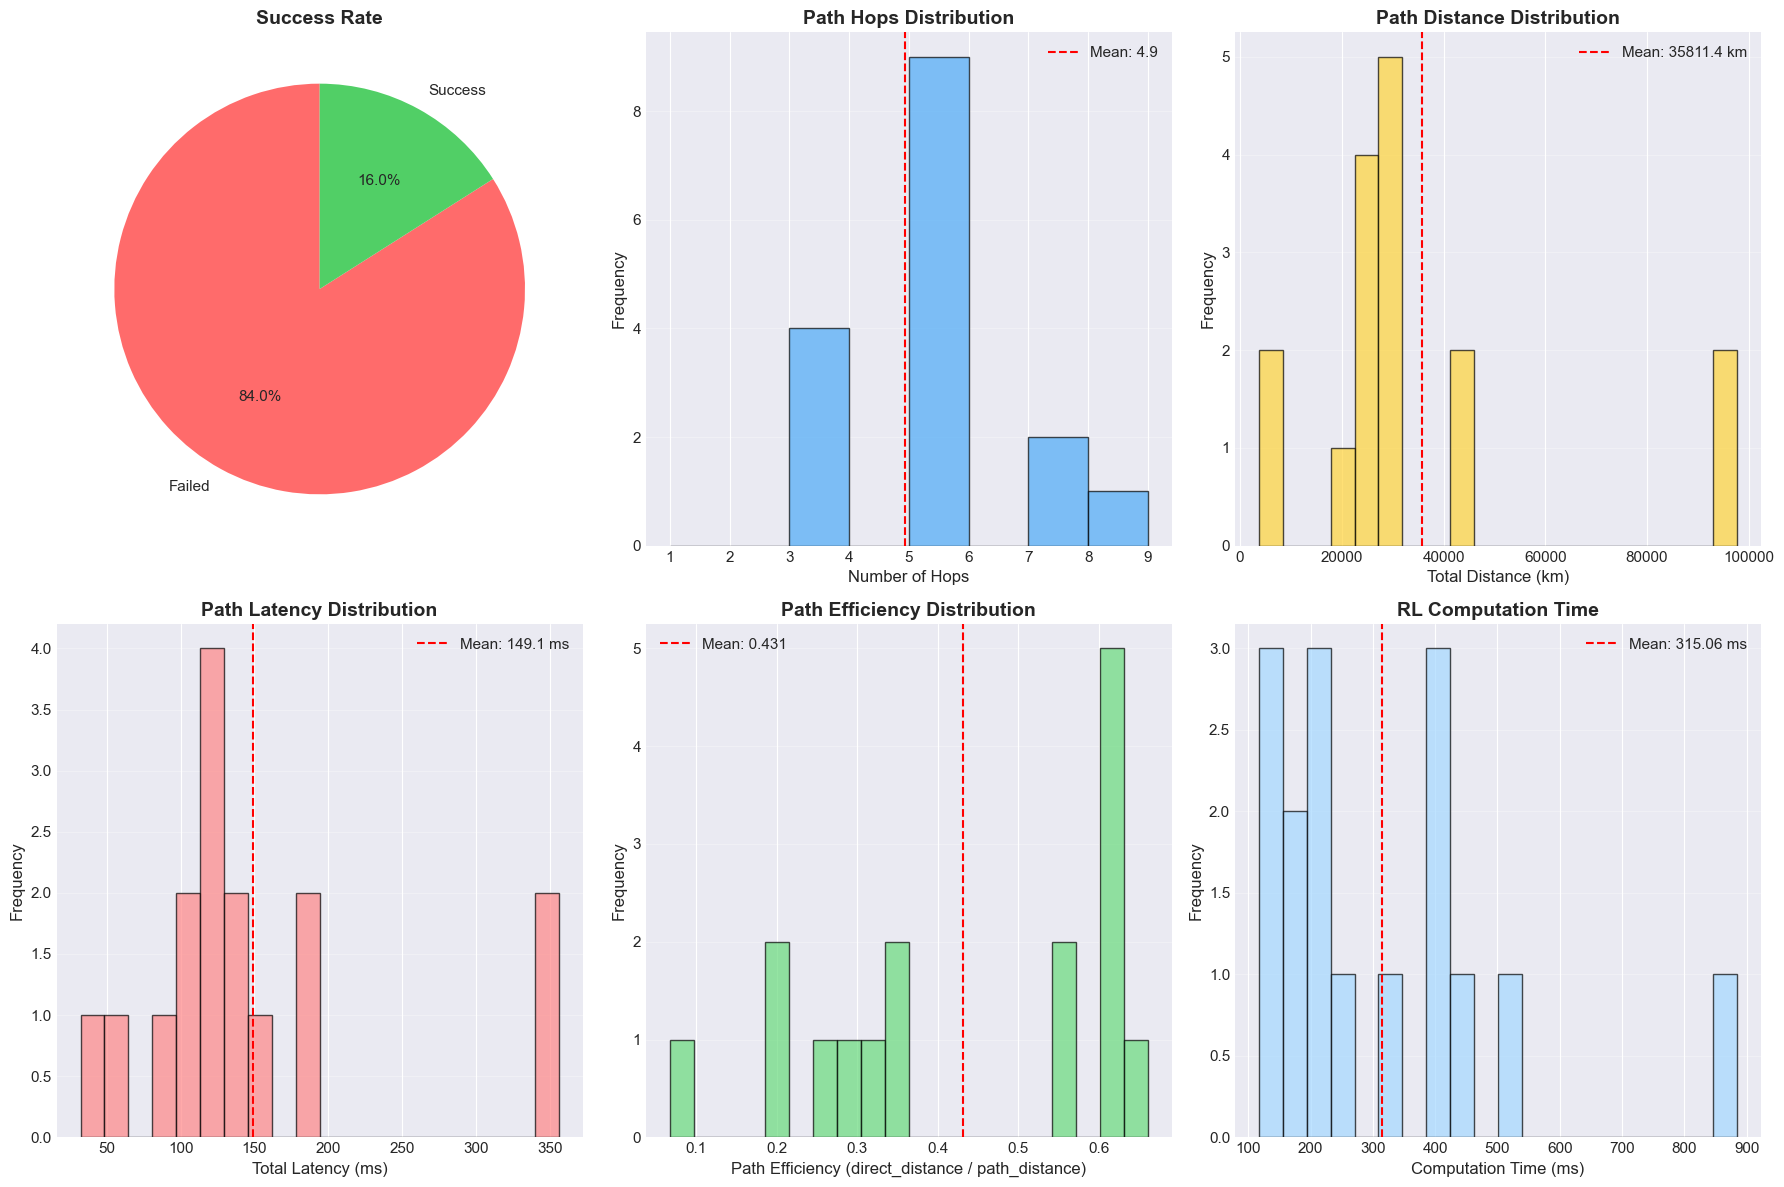


✓ Visualizations complete


In [7]:
# Visualize test results
if test_results is not None and len(test_results) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    successful_df = test_results[test_results['success'] == True]
    
    # 1. Success Rate
    ax1 = axes[0, 0]
    success_counts = test_results['success'].value_counts()
    success_count = success_counts.get(True, 0)
    failure_count = success_counts.get(False, 0)
    
    if success_count + failure_count > 0:
        values = [failure_count, success_count]
        labels = ['Failed', 'Success']
        colors_list = ['#ff6b6b', '#51cf66']
        filtered_data = [(v, l, c) for v, l, c in zip(values, labels, colors_list) if v > 0]
        if filtered_data:
            values_filtered, labels_filtered, colors_filtered = zip(*filtered_data)
            ax1.pie(values_filtered, labels=labels_filtered, autopct='%1.1f%%', 
                    colors=colors_filtered, startangle=90)
        else:
            ax1.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax1.transAxes)
    else:
        ax1.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('Success Rate', fontsize=14, fontweight='bold')
    
    # 2. Hops Distribution
    ax2 = axes[0, 1]
    if len(successful_df) > 0:
        ax2.hist(successful_df['hops'], bins=range(1, int(successful_df['hops'].max())+2), 
                edgecolor='black', alpha=0.7, color='#4dabf7')
        ax2.axvline(x=successful_df['hops'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {successful_df["hops"].mean():.1f}')
        ax2.set_xlabel('Number of Hops', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.set_title('Path Hops Distribution', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Distance Distribution
    ax3 = axes[0, 2]
    if len(successful_df) > 0:
        ax3.hist(successful_df['total_distance_km'], bins=20, edgecolor='black', 
                alpha=0.7, color='#ffd43b')
        ax3.axvline(x=successful_df['total_distance_km'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {successful_df["total_distance_km"].mean():.1f} km')
        ax3.set_xlabel('Total Distance (km)', fontsize=12)
        ax3.set_ylabel('Frequency', fontsize=12)
        ax3.set_title('Path Distance Distribution', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Latency Distribution
    ax4 = axes[1, 0]
    if len(successful_df) > 0:
        ax4.hist(successful_df['total_latency_ms'], bins=20, edgecolor='black', 
                alpha=0.7, color='#ff8787')
        ax4.axvline(x=successful_df['total_latency_ms'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {successful_df["total_latency_ms"].mean():.1f} ms')
        ax4.set_xlabel('Total Latency (ms)', fontsize=12)
        ax4.set_ylabel('Frequency', fontsize=12)
        ax4.set_title('Path Latency Distribution', fontsize=14, fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Efficiency Distribution
    ax5 = axes[1, 1]
    if len(successful_df) > 0:
        ax5.hist(successful_df['efficiency'], bins=20, edgecolor='black', 
                alpha=0.7, color='#69db7c')
        ax5.axvline(x=successful_df['efficiency'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {successful_df["efficiency"].mean():.3f}')
        ax5.set_xlabel('Path Efficiency (direct_distance / path_distance)', fontsize=12)
        ax5.set_ylabel('Frequency', fontsize=12)
        ax5.set_title('Path Efficiency Distribution', fontsize=14, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3, axis='y')
    
    # 6. Computation Time
    ax6 = axes[1, 2]
    if len(successful_df) > 0:
        ax6.hist(successful_df['computation_time_ms'], bins=20, edgecolor='black', 
                alpha=0.7, color='#a5d8ff')
        ax6.axvline(x=successful_df['computation_time_ms'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {successful_df["computation_time_ms"].mean():.2f} ms')
        ax6.set_xlabel('Computation Time (ms)', fontsize=12)
        ax6.set_ylabel('Frequency', fontsize=12)
        ax6.set_title('RL Computation Time', fontsize=14, fontweight='bold')
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Visualizations complete")


## 7. Detailed Analysis


In [12]:
# Detailed analysis
if test_results is not None and len(test_results) > 0:
    successful_df = test_results[test_results['success'] == True]
    failed_df = test_results[test_results['success'] == False]
    
    print("=" * 60)
    print("RL ROUTING ANALYSIS (BEST MODEL)")
    print("=" * 60)
    print(f"\n📊 Overall Statistics:")
    print(f"  Total tests: {len(test_results)}")
    print(f"  Successful: {len(successful_df)} ({len(successful_df)/len(test_results)*100:.1f}%)")
    print(f"  Failed: {len(failed_df)} ({len(failed_df)/len(test_results)*100:.1f}%)")
    
    if len(successful_df) > 0:
        print(f"\n✅ Successful Path Metrics:")
        print(f"  Mean hops: {successful_df['hops'].mean():.2f} (std: {successful_df['hops'].std():.2f})")
        print(f"  Min hops: {successful_df['hops'].min()}")
        print(f"  Max hops: {successful_df['hops'].max()}")
        print(f"\n  Mean distance: {successful_df['total_distance_km'].mean():.2f} km (std: {successful_df['total_distance_km'].std():.2f} km)")
        print(f"  Min distance: {successful_df['total_distance_km'].min():.2f} km")
        print(f"  Max distance: {successful_df['total_distance_km'].max():.2f} km")
        print(f"\n  Mean latency: {successful_df['total_latency_ms'].mean():.2f} ms (std: {successful_df['total_latency_ms'].std():.2f} ms)")
        print(f"  Min latency: {successful_df['total_latency_ms'].min():.2f} ms")
        print(f"  Max latency: {successful_df['total_latency_ms'].max():.2f} ms")
        print(f"\n  Mean efficiency: {successful_df['efficiency'].mean():.3f} (std: {successful_df['efficiency'].std():.3f})")
        print(f"  Mean computation time: {successful_df['computation_time_ms'].mean():.2f} ms")
    
    if len(failed_df) > 0:
        print(f"\n❌ Failure Analysis:")
        error_counts = failed_df['error'].value_counts()
        for error, count in error_counts.items():
            print(f"  {error}: {count} ({count/len(failed_df)*100:.1f}%)")
    
    # Distance vs Hops analysis
    if len(successful_df) > 0:
        print(f"\n📈 Distance vs Hops Correlation:")
        correlation = successful_df['terminal_distance_km'].corr(successful_df['hops'])
        print(f"  Correlation: {correlation:.3f}")
        
        # Group by distance ranges
        successful_df['distance_range'] = pd.cut(
            successful_df['terminal_distance_km'],
            bins=[0, 2000, 5000, 10000, float('inf')],
            labels=['Near (<2k km)', 'Medium (2-5k km)', 'Far (5-10k km)', 'Very Far (>10k km)']
        )
        
        print(f"\n📊 Performance by Distance Range:")
        for dist_range in successful_df['distance_range'].cat.categories:
            range_df = successful_df[successful_df['distance_range'] == dist_range]
            if len(range_df) > 0:
                print(f"  {dist_range}:")
                print(f"    Count: {len(range_df)}")
                print(f"    Mean hops: {range_df['hops'].mean():.2f}")
                print(f"    Mean distance: {range_df['total_distance_km'].mean():.2f} km")
                print(f"    Mean latency: {range_df['total_latency_ms'].mean():.2f} ms")
    
    print("\n" + "=" * 60)


RL ROUTING ANALYSIS (BEST MODEL)

📊 Overall Statistics:
  Total tests: 100
  Successful: 16 (16.0%)
  Failed: 84 (84.0%)

✅ Successful Path Metrics:
  Mean hops: 4.94 (std: 1.48)
  Min hops: 3
  Max hops: 8

  Mean distance: 35811.35 km (std: 26341.59 km)
  Min distance: 3700.56 km
  Max distance: 97695.92 km

  Mean latency: 149.14 ms (std: 90.13 ms)
  Min latency: 32.34 ms
  Max latency: 355.88 ms

  Mean efficiency: 0.431 (std: 0.200)
  Mean computation time: 315.06 ms

❌ Failure Analysis:
  Unknown error: 84 (100.0%)

📈 Distance vs Hops Correlation:
  Correlation: 0.077

📊 Performance by Distance Range:
  Near (<2k km):
    Count: 1
    Mean hops: 3.00
    Mean distance: 3700.56 km
    Mean latency: 32.34 ms
  Medium (2-5k km):
    Count: 1
    Mean hops: 5.00
    Mean distance: 7469.02 km
    Mean latency: 54.91 ms
  Far (5-10k km):
    Count: 2
    Mean hops: 6.50
    Mean distance: 28998.79 km
    Mean latency: 134.23 ms
  Very Far (>10k km):
    Count: 12
    Mean hops: 4.83
  

## 8. Comparison with Dijkstra


INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-079 for terminal TERM-0020 (distance: 5.5km, NO resource optimization)
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-067 for terminal TERM-1766343344708-0000 (distance: 14.4km, NO resource optimization)
INFO:api.routing_bp:⚠️ Dijkstra: Dropped 5 congested nodes (resource > 95.0%)
INFO:api.routing_bp:📐 Dijkstra (BASELINE - Pure Distance): 5 hops, 7331.7km (shortest distance), 438.61ms latency
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-055 for terminal TERM-1766343419037-0000 (distance: 24.3km, NO resource optimization)
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-079 for terminal TERM-1766343303150-0000 (distance: 20.8km, NO resource optimization)
INFO:api.routing_bp:⚠️ Dijkstra: Dropped 5 congested nodes (resource > 95.0%)
INFO:api.routing_bp:📐 Dijkstra (BASELINE - Pure Distance): 6 hops, 10739.0km (shortest di

COMPARING RL (BEST MODEL) vs DIJKSTRA


INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-055 for terminal TERM-1766343414407-0000 (distance: 19.1km, NO resource optimization)
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-067 for terminal TERM-0003 (distance: 13.2km, NO resource optimization)
INFO:api.routing_bp:⚠️ Dijkstra: Dropped 5 congested nodes (resource > 95.0%)
INFO:api.routing_bp:📐 Dijkstra (BASELINE - Pure Distance): 7 hops, 15331.0km (shortest distance), 718.57ms latency
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-059 for terminal TERM-1766343433702-0000 (distance: 31.0km, NO resource optimization)
INFO:api.routing_bp:📐 Dijkstra (BASELINE): Selected NEAREST Ground Station GS-063 for terminal TERM-1766343363456-0000 (distance: 22.4km, NO resource optimization)
INFO:api.routing_bp:⚠️ Dijkstra: Dropped 4 congested nodes (resource > 95.0%)
INFO:api.routing_bp:📐 Dijkstra (BASELINE - Pure Distance): 7 hops, 14257.1km (shortest 

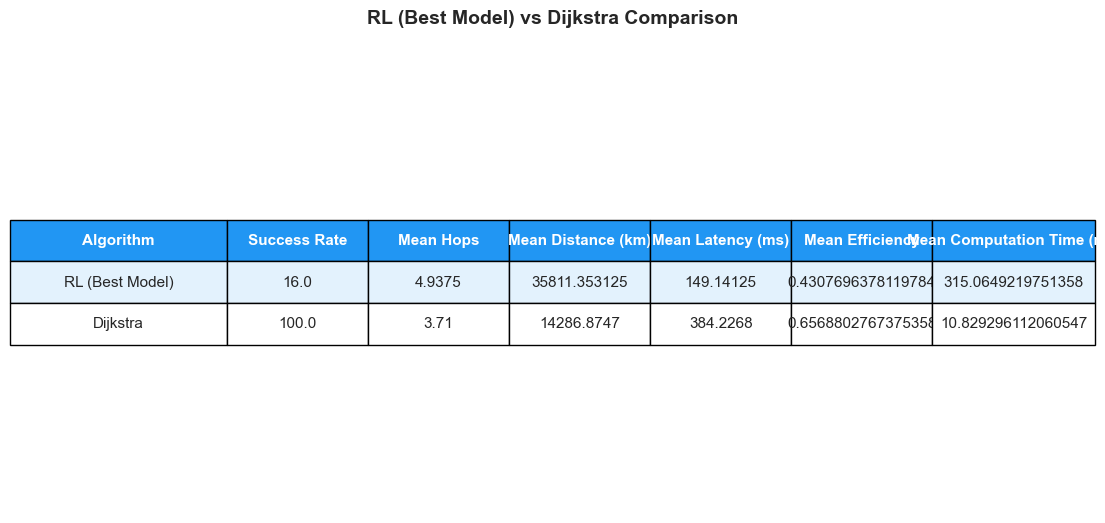


✓ Comparison complete


In [13]:
# Compare RL with Dijkstra
print("=" * 60)
print("COMPARING RL (BEST MODEL) vs DIJKSTRA")
print("=" * 60)

# Run Dijkstra tests
dijkstra_results = None
if test_results is not None:
    def test_dijkstra_routing(
        nodes: List[Dict],
        terminals: List[Dict],
        num_tests: int = 50
    ) -> pd.DataFrame:
        results = []
        for i in range(num_tests):
            terminal_indices = np.random.choice(len(terminals), size=2, replace=False)
            source_terminal = terminals[terminal_indices[0]]
            dest_terminal = terminals[terminal_indices[1]]
            
            source_pos = source_terminal.get('position', {})
            dest_pos = dest_terminal.get('position', {})
            terminal_distance = calculate_distance(source_pos, dest_pos) / 1000
            
            start_time = time.time()
            try:
                path_result = calculate_path_dijkstra(
                    source_terminal=source_terminal,
                    dest_terminal=dest_terminal,
                    nodes=nodes,
                    resource_aware=True
                )
                elapsed_time = time.time() - start_time
                
                if path_result and path_result.get('success', False):
                    path = path_result.get('path', [])
                    path_nodes = [p for p in path if p.get('type') == 'node']
                    hops = len(path_nodes)
                    total_distance = path_result.get('totalDistance', 0)
                    total_latency = path_result.get('estimatedLatency', 0)
                    efficiency = terminal_distance / total_distance if total_distance > 0 else 0
                    
                    results.append({
                        'test_id': i + 1,
                        'success': True,
                        'hops': hops,
                        'total_distance_km': total_distance,
                        'terminal_distance_km': terminal_distance,
                        'total_latency_ms': total_latency,
                        'efficiency': efficiency,
                        'computation_time_ms': elapsed_time * 1000
                    })
                else:
                    results.append({
                        'test_id': i + 1,
                        'success': False,
                        'hops': 0,
                        'total_distance_km': 0,
                        'terminal_distance_km': terminal_distance,
                        'total_latency_ms': 0,
                        'efficiency': 0,
                        'computation_time_ms': elapsed_time * 1000
                    })
            except Exception as e:
                elapsed_time = time.time() - start_time
                results.append({
                    'test_id': i + 1,
                    'success': False,
                    'hops': 0,
                    'total_distance_km': 0,
                    'terminal_distance_km': terminal_distance,
                    'total_latency_ms': 0,
                    'efficiency': 0,
                    'computation_time_ms': elapsed_time * 1000
                })
        return pd.DataFrame(results)
    
    dijkstra_results = test_dijkstra_routing(nodes, terminals, num_tests=100)

if test_results is not None and dijkstra_results is not None:
    rl_successful = test_results[test_results['success'] == True]
    dijkstra_successful = dijkstra_results[dijkstra_results['success'] == True]
    
    comparison = {
        'Algorithm': ['RL (Best Model)', 'Dijkstra'],
        'Success Rate': [
            len(rl_successful)/len(test_results)*100 if len(test_results) > 0 else 0,
            len(dijkstra_successful)/len(dijkstra_results)*100 if len(dijkstra_results) > 0 else 0
        ],
        'Mean Hops': [
            rl_successful['hops'].mean() if len(rl_successful) > 0 else 0,
            dijkstra_successful['hops'].mean() if len(dijkstra_successful) > 0 else 0
        ],
        'Mean Distance (km)': [
            rl_successful['total_distance_km'].mean() if len(rl_successful) > 0 else 0,
            dijkstra_successful['total_distance_km'].mean() if len(dijkstra_successful) > 0 else 0
        ],
        'Mean Latency (ms)': [
            rl_successful['total_latency_ms'].mean() if len(rl_successful) > 0 else 0,
            dijkstra_successful['total_latency_ms'].mean() if len(dijkstra_successful) > 0 else 0
        ],
        'Mean Efficiency': [
            rl_successful['efficiency'].mean() if len(rl_successful) > 0 else 0,
            dijkstra_successful['efficiency'].mean() if len(dijkstra_successful) > 0 else 0
        ],
        'Mean Computation Time (ms)': [
            rl_successful['computation_time_ms'].mean() if len(rl_successful) > 0 else 0,
            dijkstra_successful['computation_time_ms'].mean() if len(dijkstra_successful) > 0 else 0
        ]
    }
    
    comparison_df = pd.DataFrame(comparison)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('off')
    table = ax.table(cellText=comparison_df.values, colLabels=comparison_df.columns,
                    cellLoc='center', loc='center', colWidths=[0.2, 0.13, 0.13, 0.13, 0.13, 0.13, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    ax.set_title('RL (Best Model) vs Dijkstra Comparison', fontsize=14, fontweight='bold', pad=20)
    
    # Style table
    for i in range(len(comparison_df.columns)):
        table[(0, i)].set_facecolor('#2196F3')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Highlight RL row
    for col_idx in range(len(comparison_df.columns)):
        table[(1, col_idx)].set_facecolor('#e3f2fd')
    
    plt.show()
    
    print(f"\n✓ Comparison complete")


## 9. Summary Statistics Table


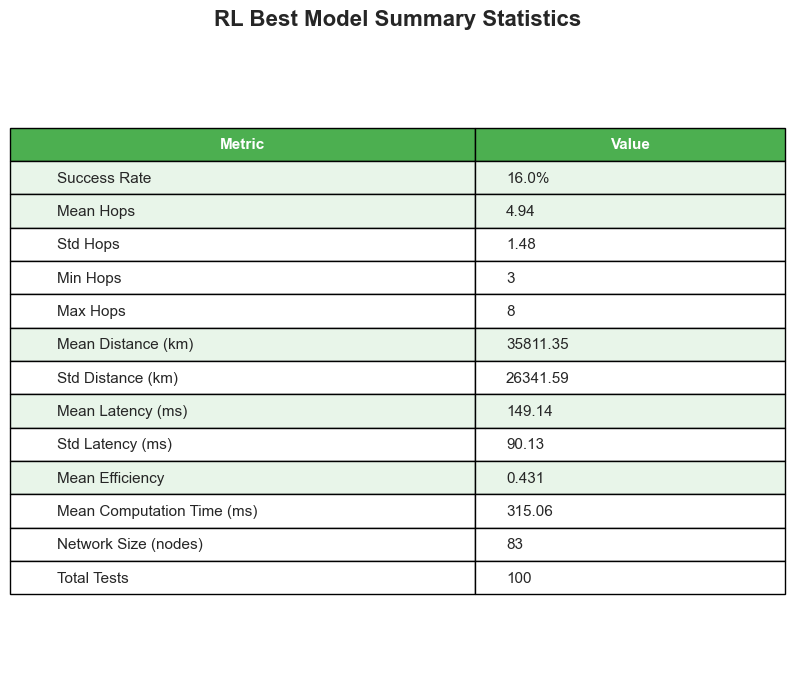


✓ Summary statistics displayed


In [10]:
# Create summary statistics table
if test_results is not None and len(test_results) > 0:
    successful_df = test_results[test_results['success'] == True]
    
    if len(successful_df) > 0:
        summary_stats = {
            'Metric': [
                'Success Rate',
                'Mean Hops',
                'Std Hops',
                'Min Hops',
                'Max Hops',
                'Mean Distance (km)',
                'Std Distance (km)',
                'Mean Latency (ms)',
                'Std Latency (ms)',
                'Mean Efficiency',
                'Mean Computation Time (ms)',
                'Network Size (nodes)',
                'Total Tests'
            ],
            'Value': [
                f"{len(successful_df)/len(test_results)*100:.1f}%",
                f"{successful_df['hops'].mean():.2f}",
                f"{successful_df['hops'].std():.2f}",
                f"{successful_df['hops'].min()}",
                f"{successful_df['hops'].max()}",
                f"{successful_df['total_distance_km'].mean():.2f}",
                f"{successful_df['total_distance_km'].std():.2f}",
                f"{successful_df['total_latency_ms'].mean():.2f}",
                f"{successful_df['total_latency_ms'].std():.2f}",
                f"{successful_df['efficiency'].mean():.3f}",
                f"{successful_df['computation_time_ms'].mean():.2f}",
                f"{operational_nodes}",
                f"{len(test_results)}"
            ]
        }
        
        summary_df = pd.DataFrame(summary_stats)
        
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.axis('off')
        table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns,
                        cellLoc='left', loc='center', colWidths=[0.6, 0.4])
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2)
        ax.set_title('RL Best Model Summary Statistics', fontsize=16, fontweight='bold', pad=20)
        
        # Style table
        for i in range(len(summary_df.columns)):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Highlight key metrics
        key_rows = [0, 1, 5, 7, 9]
        for row_idx in key_rows:
            if row_idx < len(summary_df):
                for col_idx in range(len(summary_df.columns)):
                    table[(row_idx + 1, col_idx)].set_facecolor('#e8f5e9')
        
        plt.show()
        
        print(f"\n✓ Summary statistics displayed")


## 10. Final Summary


In [11]:
# Generate final summary
print("=" * 60)
print("RL BEST MODEL TEST SUMMARY")
print("=" * 60)
print(f"\nTest Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

if test_results is not None:
    successful_df = test_results[test_results['success'] == True]
    
    print(f"\n📊 Network Configuration:")
    print(f"  Operational nodes: {operational_nodes}")
    print(f"  Total terminals: {len(terminals)}")
    
    print(f"\n✅ Routing Performance:")
    print(f"  Success rate: {len(successful_df)/len(test_results)*100:.1f}%")
    if len(successful_df) > 0:
        print(f"  Mean hops: {successful_df['hops'].mean():.2f}")
        print(f"  Mean distance: {successful_df['total_distance_km'].mean():.2f} km")
        print(f"  Mean latency: {successful_df['total_latency_ms'].mean():.2f} ms")
        print(f"  Mean efficiency: {successful_df['efficiency'].mean():.3f}")
        print(f"  Mean computation time: {successful_df['computation_time_ms'].mean():.2f} ms")
    
    print(f"\n💡 Key Findings:")
    if len(successful_df) > 0:
        if successful_df['efficiency'].mean() > 0.8:
            print("  ✓ Path efficiency is good (>0.8)")
        else:
            print("  ⚠️ Path efficiency could be improved (<0.8)")
        
        if successful_df['hops'].mean() < 5:
            print("  ✓ Average path length is reasonable (<5 hops)")
        else:
            print("  ⚠️ Average path length is high (>=5 hops)")
        
        if len(successful_df)/len(test_results) > 0.9:
            print("  ✓ Success rate is excellent (>90%)")
        elif len(successful_df)/len(test_results) > 0.7:
            print("  ✓ Success rate is good (70-90%)")
        else:
            print("  ⚠️ Success rate is low (<70%) - may need more training")
    
    if dijkstra_results is not None:
        dijkstra_successful = dijkstra_results[dijkstra_results['success'] == True]
        if len(successful_df) > 0 and len(dijkstra_successful) > 0:
            print(f"\n📊 Comparison with Dijkstra:")
            print(f"  RL Success Rate: {len(successful_df)/len(test_results)*100:.1f}%")
            print(f"  Dijkstra Success Rate: {len(dijkstra_successful)/len(dijkstra_results)*100:.1f}%")
            print(f"  RL Mean Efficiency: {successful_df['efficiency'].mean():.3f}")
            print(f"  Dijkstra Mean Efficiency: {dijkstra_successful['efficiency'].mean():.3f}")
            print(f"  RL Mean Hops: {successful_df['hops'].mean():.2f}")
            print(f"  Dijkstra Mean Hops: {dijkstra_successful['hops'].mean():.2f}")
    
    print(f"\n📈 Recommendations:")
    if len(successful_df) == 0:
        print("  ⚠️ No successful paths found. Check:")
        print("     - Model loading")
        print("     - Network connectivity")
        print("     - Node operational status")
    elif len(successful_df)/len(test_results) < 0.7:
        print("  ⚠️ Low success rate. Consider:")
        print("     - Retraining the model")
        print("     - Adjusting hyperparameters")
        print("     - Adding more training episodes")
    else:
        print("  ✓ RL model is performing well")
        if dijkstra_results is not None:
            dijkstra_successful = dijkstra_results[dijkstra_results['success'] == True]
            if len(successful_df) > 0 and len(dijkstra_successful) > 0:
                if successful_df['efficiency'].mean() > dijkstra_successful['efficiency'].mean():
                    print("     - RL efficiency is better than Dijkstra!")
                elif successful_df['efficiency'].mean() >= dijkstra_successful['efficiency'].mean() * 0.9:
                    print("     - RL efficiency is comparable to Dijkstra")
                else:
                    print("     - RL efficiency is lower than Dijkstra - may need more training")

print("\n" + "=" * 60)
print("✅ Test Complete")
print("=" * 60)


RL BEST MODEL TEST SUMMARY

Test Date: 2025-12-22 17:44:43

📊 Network Configuration:
  Operational nodes: 83
  Total terminals: 92

✅ Routing Performance:
  Success rate: 16.0%
  Mean hops: 4.94
  Mean distance: 35811.35 km
  Mean latency: 149.14 ms
  Mean efficiency: 0.431
  Mean computation time: 315.06 ms

💡 Key Findings:
  ⚠️ Path efficiency could be improved (<0.8)
  ✓ Average path length is reasonable (<5 hops)
  ⚠️ Success rate is low (<70%) - may need more training

📊 Comparison with Dijkstra:
  RL Success Rate: 16.0%
  Dijkstra Success Rate: 100.0%
  RL Mean Efficiency: 0.431
  Dijkstra Mean Efficiency: 0.621
  RL Mean Hops: 4.94
  Dijkstra Mean Hops: 3.68

📈 Recommendations:
  ⚠️ Low success rate. Consider:
     - Retraining the model
     - Adjusting hyperparameters
     - Adding more training episodes

✅ Test Complete
